# Customer Segmentation

## Step 0 : Setup

### Import Libraries

In [1]:
import ipywidgets
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### Read the Dataset

In [2]:
# Download the dataset and construct the file path
file_path = f"{kagglehub.dataset_download('shwetabh123/mall-customers')}/Mall_Customers.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Step 1 : Data Cleaning

In [3]:
# Rename the 'Genre' column to 'Gender'
df.rename(columns={'Genre': 'Gender'}, inplace=True)

# Drop the 'CustomerID' column because it's irrelevant for clustering
df.drop('CustomerID', axis=1, inplace=True)

# Display the first few rows of the DataFrame to confirm the changes
print("DataFrame after renaming 'Genre' and dropping 'CustomerID':\n")
df.head()

DataFrame after renaming 'Genre' and dropping 'CustomerID':



,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Step 2 : Exploratory Data Analysis (EDA)

### Data Inspection

In [4]:
df.shape

(200, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [6]:
print("\nMissing values in each column:\n", df.isnull().sum())


Missing values in each column:
 Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [7]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


### Simple Data Visualization

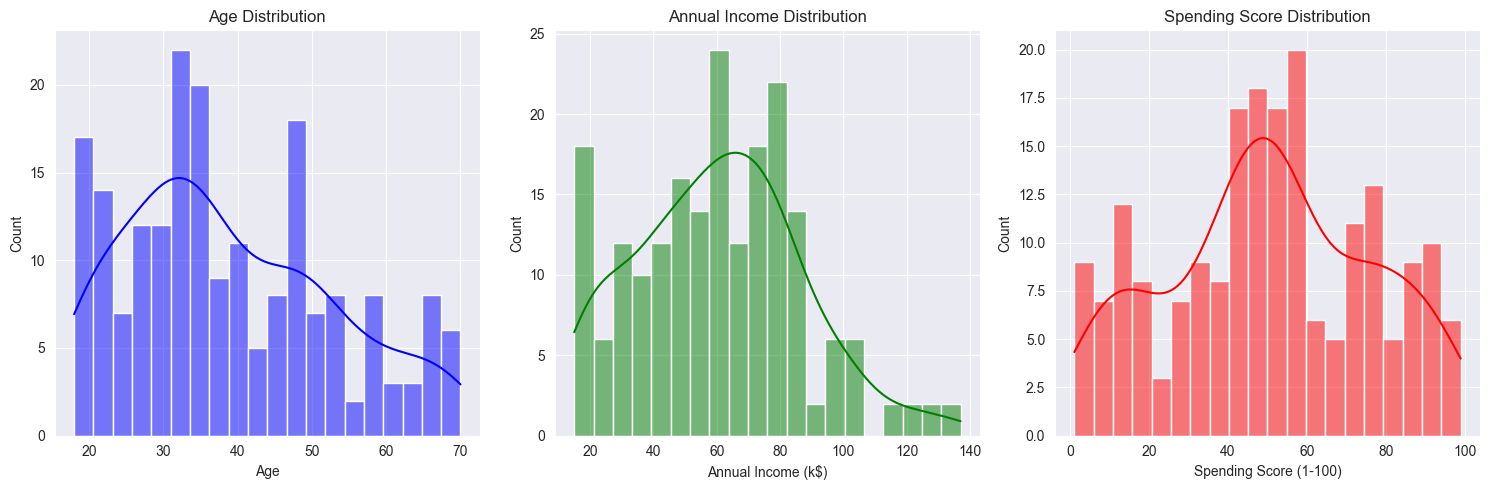

In [8]:
# Create a figure to hold the subplots
plt.figure(figsize=(15, 5))

# Plot for Age
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution')

# Plot for Annual Income
plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, color='green')
plt.title('Annual Income Distribution')

# Plot for Spending Score
plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True, color='red')
plt.title('Spending Score Distribution')

plt.tight_layout()
plt.show()

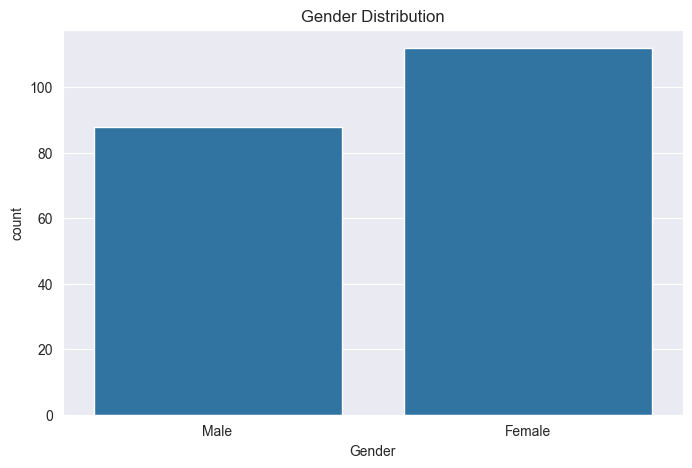

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.show()

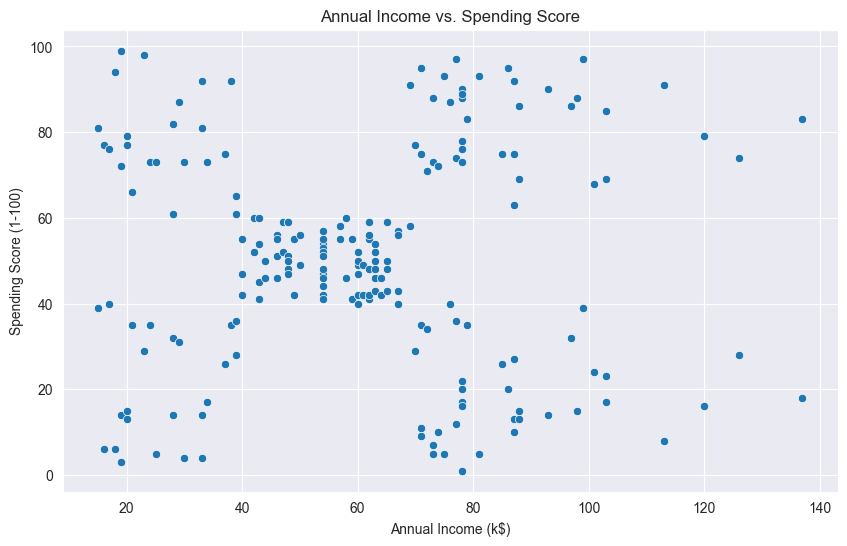

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df)
plt.title('Annual Income vs. Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Advanced Data Visualization

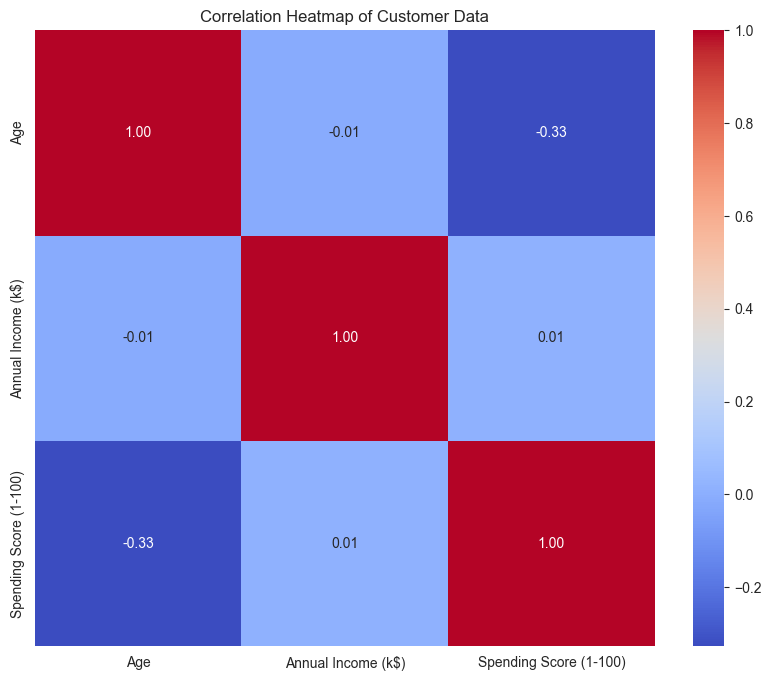

In [11]:
# Calculate the correlation matrix for numerical columns
corr = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()

plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Customer Data')
plt.show()

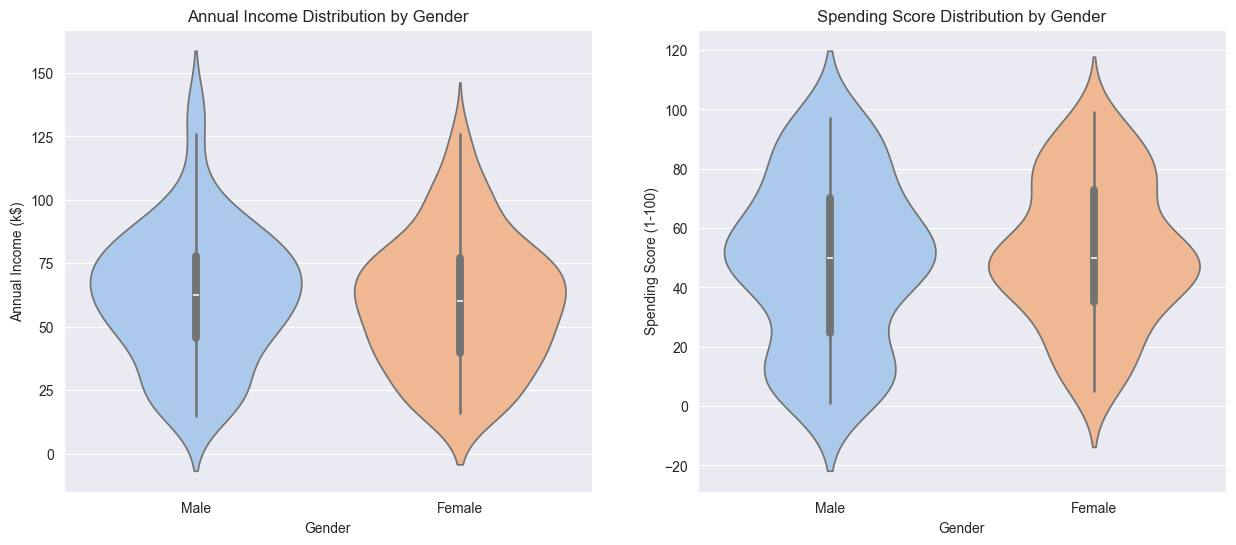

In [12]:
plt.figure(figsize=(15, 6))

# Plot for Annual Income by Gender
plt.subplot(1, 2, 1)
sns.violinplot(x='Gender', y='Annual Income (k$)', data=df, palette='pastel', hue='Gender', legend=False)
plt.title('Annual Income Distribution by Gender')

# Plot for Spending Score by Gender
plt.subplot(1, 2, 2)
sns.violinplot(x='Gender', y='Spending Score (1-100)', data=df, palette='pastel', hue='Gender', legend=False)
plt.title('Spending Score Distribution by Gender')

plt.show()

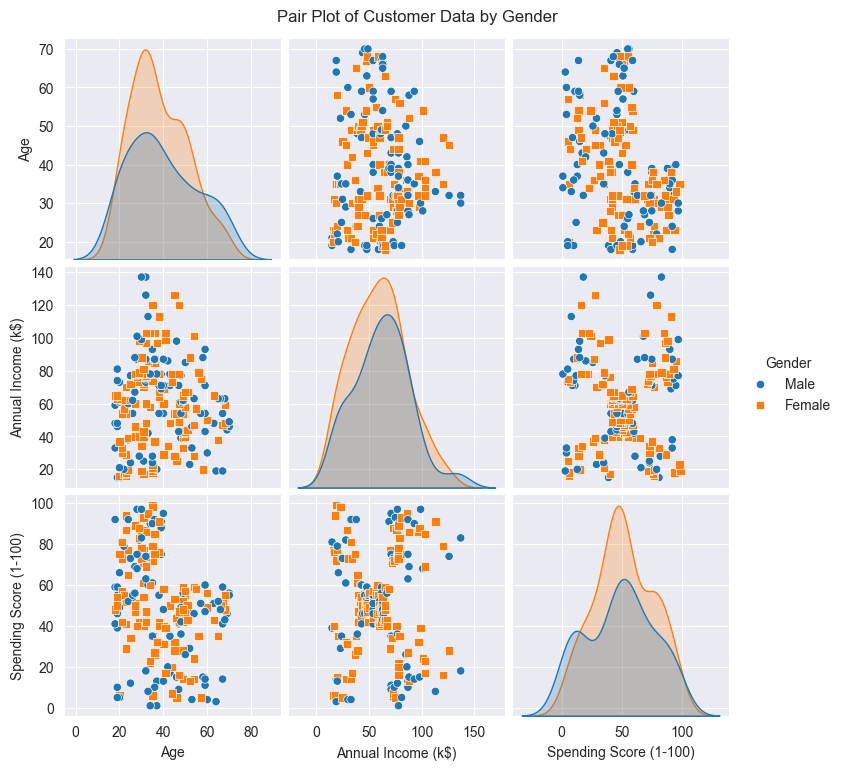

In [13]:
# Pair plot to visualize relationships between all numerical variables
# hue='Gender' will color the points based on the customer's gender
sns.pairplot(df, hue='Gender', markers=['o', 's'])
plt.suptitle('Pair Plot of Customer Data by Gender', y=1.02)
plt.show()

## Step 3 : Data Preprocessing

### Encode Categorical Variables

In [14]:
# Encode the 'Gender' column directly on the df
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

### Feature Scaling

In [15]:
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Fit and transform the numerical columns, updating them in the original df
df[numerical_cols] = StandardScaler().fit_transform(df[numerical_cols])

# Display the first few rows to show the changes
print("DataFrame after in-place Encoding and Scaling:")
df.head()

DataFrame after in-place Encoding and Scaling:


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,-1.424569,-1.738999,-0.434801
1,0,-1.281035,-1.738999,1.195704
2,1,-1.352802,-1.700830,-1.715913
3,1,-1.137502,-1.700830,1.040418
4,1,-0.563369,-1.662660,-0.395980
